In [220]:
import torchaudio
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import pandas as pd
import librosa
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [121]:
path = 'Crema'

audios = []
labels = []

In [122]:
for file in os.listdir(path):
    this_file = path + '/' + file
    audios.append(torchaudio.load(this_file))
    labels.append(file.split('_')[2])

In [123]:
len(labels)

7442

In [232]:
set(labels)

{0, 1, 2, 3, 4, 5}

In [124]:
def audio_for_class(audio_list, label_list):
    samples = {label:None for label in set(label_list)}
    for label,audio in zip(label_list,audio_list):
        if samples[label]==None:
            samples[label] = audio
            
    return samples

In [125]:
# Taken from torchaudio docs
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)
  
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [126]:
samples = audio_for_class(audios, labels)

In [127]:
samples['ANG']

(tensor([[0.0090, 0.0108, 0.0115,  ..., 0.0000, 0.0000, 0.0000]]), 16000)

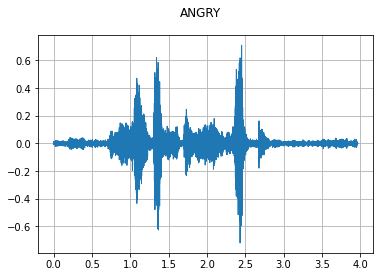

In [128]:
# ANGRY
plot_waveform(samples['ANG'][0],samples['ANG'][1], title='ANGRY')
play_audio(samples['ANG'][0],samples['ANG'][1])

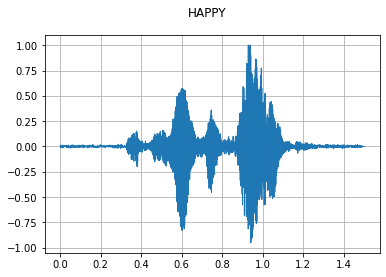

In [129]:
# HAPPY
plot_waveform(samples['HAP'][0],samples['HAP'][1], title='HAPPY')
play_audio(samples['HAP'][0],samples['HAP'][1])

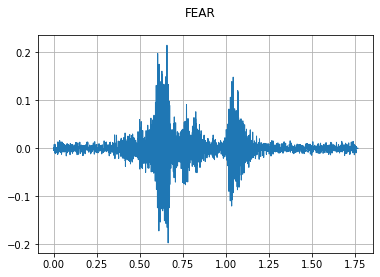

In [130]:
# FEAR
plot_waveform(samples['FEA'][0],samples['FEA'][1], title='FEAR')
play_audio(samples['FEA'][0],samples['FEA'][1])

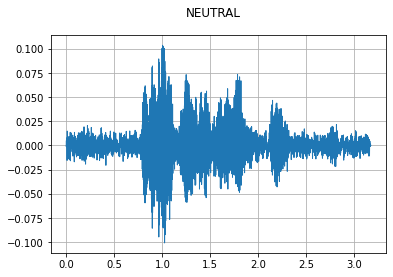

In [131]:
# NEUTRAL
plot_waveform(samples['NEU'][0],samples['NEU'][1], title='NEUTRAL')
play_audio(samples['NEU'][0],samples['NEU'][1])

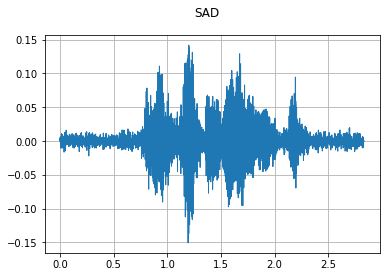

In [132]:
# SAD
plot_waveform(samples['SAD'][0],samples['SAD'][1], title='SAD')
play_audio(samples['SAD'][0],samples['SAD'][1])

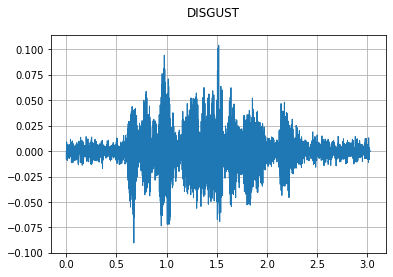

In [133]:
# DISGUST
plot_waveform(samples['DIS'][0],samples['DIS'][1], title='DISGUST')
play_audio(samples['DIS'][0],samples['DIS'][1])

In [134]:
def pad(lst, dim=1):
    new_lst = []
    if dim==1:
        max_len = len(max(lst,key=len))
        for l in lst:
            if len(l)<max_len:
                l = np.pad(l,(1,max_len-len(l)-1))
            
            new_lst.append(l)
    elif dim==2:
        max_len = max(len(max(lst[0],key=len)), len(max(lst[1],key=len)))
        for ls in lst:
            new_ls = []
            for l in ls:
                if len(l)<max_len:
                    l = np.pad(l,(1,max_len-len(l)-1))
                
                new_ls.append(l)
            new_lst.append(new_ls)
    
    return np.array(new_lst)

In [273]:
def extract_features(audio_data, features={'ZCST', 'ENE'}, frame_length=2048, hop_length=128, tensor_data=None):
    space = []
    zcst = []
    ene = []
    mel = []
    transform = torchaudio.transforms.MelSpectrogram()
    for i,audio in enumerate(audio_data):
        if 'MEL' in features and not tensor_data==None:
            mel.append(transform(tensor_data[i]))
        else:
            zcs = librosa.feature.zero_crossing_rate(audio).reshape(-1)
            zcst.append(zcs)

            energy = np.array([np.sum(audio[i:i+frame_length]**2)/frame_length for i in range(0,len(audio),hop_length)])
            ene.append(energy)
            
    if 'MEL' in features:
        space = pad(mel)
    else:
        space = np.concatenate((pad(zcst), pad(ene)), axis=1)
            
    return space

In [136]:
FS = audios[0][1]
audios = [audio[0] for audio in audios]

In [137]:
len(audios)

7442

In [138]:
audios_np = [np.array(audio).reshape(-1) for audio in audios]

In [139]:
df = pd.concat([pd.Series(audios_np, name='waveforms'), pd.Series(labels,name='Labels')], axis=1)
df

,waveforms,Labels
0,"[0.008972168, 0.01083374, 0.011474609, 0.01324...",ANG
1,"[0.0010681152, 0.0009460449, 0.00048828125, 0....",FEA
2,"[0.00030517578, -0.00039672852, -0.0010070801,...",DIS
3,"[0.004425049, 0.0036010742, 0.003112793, 0.003...",SAD
4,"[-0.0024414062, -0.0029296875, -0.002380371, -...",SAD
...,...,...
7437,"[0.008392334, 0.009033203, 0.009460449, 0.0086...",DIS
7438,"[-0.0016174316, -0.0020141602, -0.0022583008, ...",SAD
7439,"[0.00015258789, 0.00079345703, 0.00076293945, ...",DIS
7440,"[-0.0025634766, -0.0017089844, -0.00289917, -0...",FEA


In [340]:
space_1d = extract_features(df['waveforms'].to_numpy())

/home/mohab/.local/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [309]:
space_1d = np.expand_dims(space_1d, 1).reshape((7442,1,783))

In [169]:
space_1d = space_1d.reshape((7442,2,626)).astype('double')

In [341]:
space_1d.shape

(7442, 783)

In [221]:
le = LabelEncoder()

labels = le.fit_transform(labels)

In [41]:
sp = extract_features(df['waveforms'].to_numpy(), features={'MEL'}, tensor_data=audios)

/home/mohab/.local/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [50]:
sp[0].reshape(128,318).size()

torch.Size([128, 318])

In [24]:
sp[0].shape

(7442, 157)

In [25]:
sp[1].shape

(7442, 626)

In [37]:
tf = torchaudio.transforms.MelSpectrogram()

/home/mohab/.local/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [348]:
class SpeechEmotion(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv1d(in_channels=783, out_channels=512, kernel_size=5, stride=1),
                        nn.ReLU(),
                        nn.MaxPool1d(kernel_size=5, stride=2)
        )

        self.layer2 = nn.Sequential(
                        nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5, stride=1),
                        nn.ReLU(),
                        nn.MaxPool1d(kernel_size=5, stride=2)
        )

        self.layer3 = nn.Sequential(
                        nn.Conv1d(in_channels=512, out_channels=1, kernel_size=5, stride=1),
                        nn.ReLU(),
                        nn.MaxPool1d(kernel_size=5, stride=2)
        )
        # self.c1 = nn.Conv1d(in_channels=2, out_channels=512, kernel_size=5, stride=1)
        # self.relu1 = nn.ReLU()
        # self.max_pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        
        # self.c2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5, stride=1)
        # self.relu2 = nn.ReLU()
        # self.max_pool2 = nn.MaxPool1d(kernel_size=5, stride=2)
        
        # self.c3 = nn.Conv1d(in_channels=512, out_channels=128, kernel_size=5, stride=1)
        # self.relu3 = nn.ReLU()
        # self.max_pool3 = nn.MaxPool1d(kernel_size=5, stride=2)

        self.fc = nn.Sequential(
                    nn.Linear(91,256),
                    # nn.Linear(1,256),
                    nn.ReLU(),
                    nn.Linear(256,6),
                    nn.Softmax(1)
        )
        
        # self.fc1 = nn.Linear(72,256)
        # self.relufc1 = nn.ReLU()
        
        # self.fc2 = nn.Linear(256, 5)
        # self.soft_max = nn.Softmax(5)

    def forward(self, x):
        # x = self.c1(x)
        # x = self.relu1(x)
        # x = self.max_pool1(x)

        # x = self.c2(x)
        # x = self.relu2(x)
        # x = self.max_pool2(x)

        # x = self.c3(x)
        # x = self.relu3(x)
        # x = self.max_pool3(x)

        # x = self.fc1(x)
        # x = self.relufc1(x)

        # x = self.fc2(x)
        # x = self.soft_max(x)

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.fc(x)

        return x

In [349]:
model = SpeechEmotion()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [342]:
X_train, X_test, y_train, y_test = train_test_split(space_1d, np.array(labels), test_size=0.3, train_size=0.7, random_state=42, stratify=labels)

In [338]:
X_train.shape

(5209, 1, 783)

In [339]:
y_train.shape

(5209,)

In [193]:
class DataLoadClass(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        super(DataLoadClass).__init__()
        self.data = data
        self.labels = labels

    def __getitem__(self, key):
        # print(self.data[key].shape)
        return self.data[key].astype(np.double), self.labels[key]
    
    def __len__(self):
        return self.data.shape[0]

In [343]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(DataLoadClass(X_train, y_train), batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(DataLoadClass(X_test, y_test), batch_size=batch_size, shuffle=True)

In [350]:
n_epochs = 20
for epoch in range(n_epochs):
    for inputs_set, labels_set in trainloader:
        # forward, backward, and then weight update
        # print(inputs_set.size())
        # inputs_set = inputs_set.permute(1,0,2)
        y_pred = model(inputs_set.float())
        loss = loss_fn(y_pred.squeeze(), labels_set.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    acc = 0
    count = 0
    for inputs_set, labels_set in testloader:
        y_pred = model(inputs_set.float())
        acc += (torch.argmax(y_pred.squeeze(), 1) == labels_set).float().sum()
        count += len(labels_set)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

RuntimeError: Given groups=1, weight of size [512, 783, 5], expected input[1, 32, 783] to have 783 channels, but got 32 channels instead